### Initialization of pandas dataframe

In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

df = pd.read_csv("raw_data.csv")
df = df.drop(columns=['index'])

### Compute Pearson correlation between the prices of the two crops

In [7]:
from itertools import combinations

unique_crops = df['crop'].unique()

crop_pairs = list(combinations(unique_crops, 2))
correlation_results = {}

# Loop through each crop pair
for crop1, crop2 in crop_pairs:
    # Select data for the first crop
    crop1_data = df[df['crop'] == crop1]
    
    # Select data for the second crop
    crop2_data = df[df['crop'] == crop2]
    
    # Merge data for the two crops based on 'year' and 'month'
    merged_data = pd.merge(crop1_data, crop2_data, on=['year', 'month'])
    
    # Compute Pearson correlation between the prices of the two crops
    correlation = merged_data['price_x'].corr(merged_data['price_y'])
    
    # Store the correlation coefficient in the dictionary
    correlation_results[(crop1, crop2)] = correlation

# Convert dictionary to DataFrame for easier analysis
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Pearson Correlation'])

# Print or further analyze the correlation DataFrame
print(correlation_df)

                                                    Pearson Correlation
(RICE, WELL-MILLED, 1 KG, RICE, REGULAR-MILLED,...             0.992289
(RICE, WELL-MILLED, 1 KG, RICE, SPECIAL, 1 KG)                 0.993633
(RICE, WELL-MILLED, 1 KG, CORN GRITS, CORN NATI...             0.440974
(RICE, WELL-MILLED, 1 KG, CORN GRITS, LOOSE, 1 KG)             0.678199
(RICE, WELL-MILLED, 1 KG, CORN GRITS, WHITE, #1...             0.599886
...                                                                 ...
(FRESH SQUID, MEDIUM, 1 KG, FRESH SEAWEEDS, GUL...             0.874315
(FRESH SQUID, MEDIUM, 1 KG, FRESH SEAWEEDS, LAT...             0.913569
(FRESH SEA SNAILS, 1 KG, FRESH SEAWEEDS, GULAMA...             0.299026
(FRESH SEA SNAILS, 1 KG, FRESH SEAWEEDS, LATO, ...             0.221071
(FRESH SEAWEEDS, GULAMAN DAGAT, 1 KG, FRESH SEA...             0.826354

[20100 rows x 1 columns]


In [16]:
sorted_correlation_df = correlation_df.sort_values(by='Pearson Correlation', ascending=False)

# Display the top 10 correlations
print("Top 10 correlations:")
sorted_correlation_df.head(50)

Top 10 correlations:


,Pearson Correlation
"(FRESH BEEF, MEAT WITH BONES, 1 KG, FRESH BEEF, PURE MEAT, 1 KG)",0.997300
"(EDIBLE OFFAL, GIZZARD, CHICKEN, 1 KG, EDIBLE OFFAL, LIVER, CHICKEN, FRESH, 1 KG)",0.995992
"(FRESH PORK, MEAT WITH BONES, 1 KG, EDIBLE OFFAL, LIVER, PORK, 1 KG)",0.994097
"(FRESH PORK, KASIM, 1 KG, EDIBLE OFFAL, LIVER, PORK, 1 KG)",0.993881
"(RICE, WELL-MILLED, 1 KG, RICE, SPECIAL, 1 KG)",0.993633
"(RICE, WELL-MILLED, 1 KG, RICE, REGULAR-MILLED, 1 KG)",0.992289
"(FRESH BEEF, MEAT WITH BONES, 1 KG, EDIBLE OFFAL, GIZZARD, CHICKEN, 1 KG)",0.991132
"(FRESH EGG, CHICKEN, MEDIUM, 1 PC, FRESH EGG, DUCK, MEDIUM, 1 PC)",0.990851
"(FRESH BEEF, PURE MEAT, 1 KG, EDIBLE OFFAL, GIZZARD, CHICKEN, 1 KG)",0.990304
"(FRESH PORK, KASIM, 1 KG, FRESH PORK, MEAT WITH BONES, 1 KG)",0.988613


In [13]:

# Display the bottom 10 correlations
print("\nBottom 10 correlations:")
sorted_correlation_df.tail(50)


Bottom 10 correlations:


,Pearson Correlation
"(GINGER, LOOSE, 1 KG, FRESH FISH, MILKFISH, BANGUS, MEDIUM, 1 KG)",-0.884005
"(GINGER, LOOSE, 1 KG, FRESH SHRIMP, SUGPO, MEDIUM, 1 KG)",-0.884235
"(GINGER, LOOSE, 1 KG, FRESH FISH, SNAPPER, MAYA-MAYA, MEDIUM, 1 KG)",-0.884614
"(PALAWAN, YELLOW, 1 KG, FRESH FISH, NEMIMTERID, BISUGO, MEDIUM, 1 KG)",-0.886654
"(GINGER, LOOSE, 1 KG, EDIBLE OFFAL, GIZZARD, CHICKEN, 1 KG)",-0.887564
"(GINGER, LOOSE, 1 KG, FRESH FISH, BUROT, MEDIUM, 1 KG)",-0.888145
"(PALAWAN, YELLOW, 1 KG, EDIBLE OFFAL, GIZZARD, CHICKEN, LOOSE, 1 KG)",-0.888617
"(KARLANG, 1 KG, MONGGO, GREEN, 1 KG)",-0.888872
"(GINGER, LOOSE, 1 KG, FRESH SHELLS, TAHONG, 1 KG)",-0.889067
"(PALAWAN, YELLOW, 1 KG, FRESH FISH, CAESIO, DALAGANG-BUKID, MEDIUM, 1 KG)",-0.889733


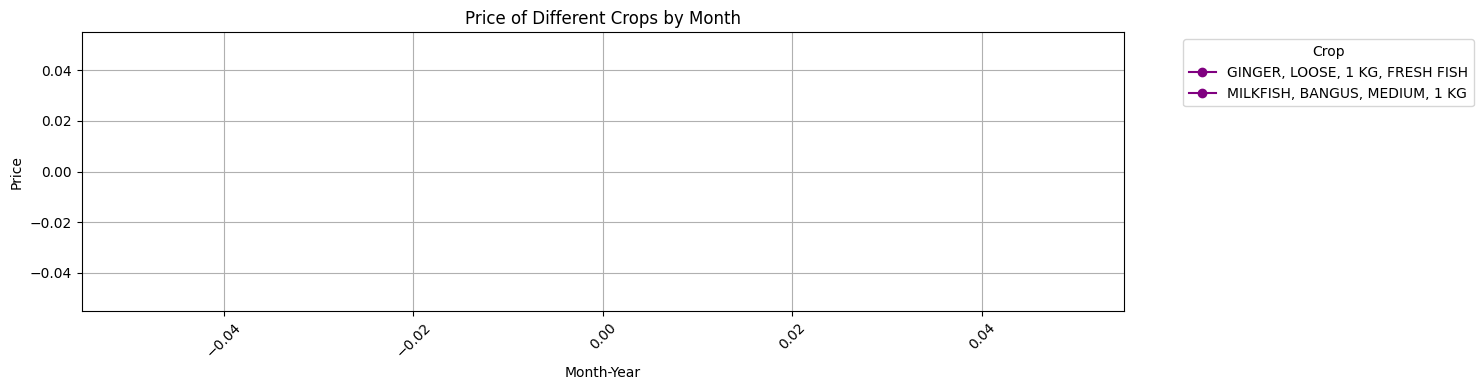

In [15]:
plt.figure(figsize=(15, 4))


# Get unique crops
# unique_crops = df['crop'].unique()
unique_crops = ["GINGER, LOOSE, 1 KG, FRESH FISH", "MILKFISH, BANGUS, MEDIUM, 1 KG"]
# Plot each crop separately
for crop in unique_crops:
    crop_df = df[df['crop'] == crop]
    plt.plot(crop_df['month'] + '-' + crop_df['year'].astype(str), crop_df['price'], marker='o', label=crop, color='purple')

plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.title('Price of Different Crops by Month')
plt.xticks(rotation=45)
plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Displaying the plot
plt.show()